In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,GlobalAveragePooling2D,Activation
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [35]:
data = tf.keras.utils.image_dataset_from_directory('data',image_size=(225, 225))

Found 2457 files belonging to 5 classes.


In [5]:
iterator = data.as_numpy_iterator()

In [6]:
batch = iterator.next()

In [7]:
batch[1].shape

(32,)

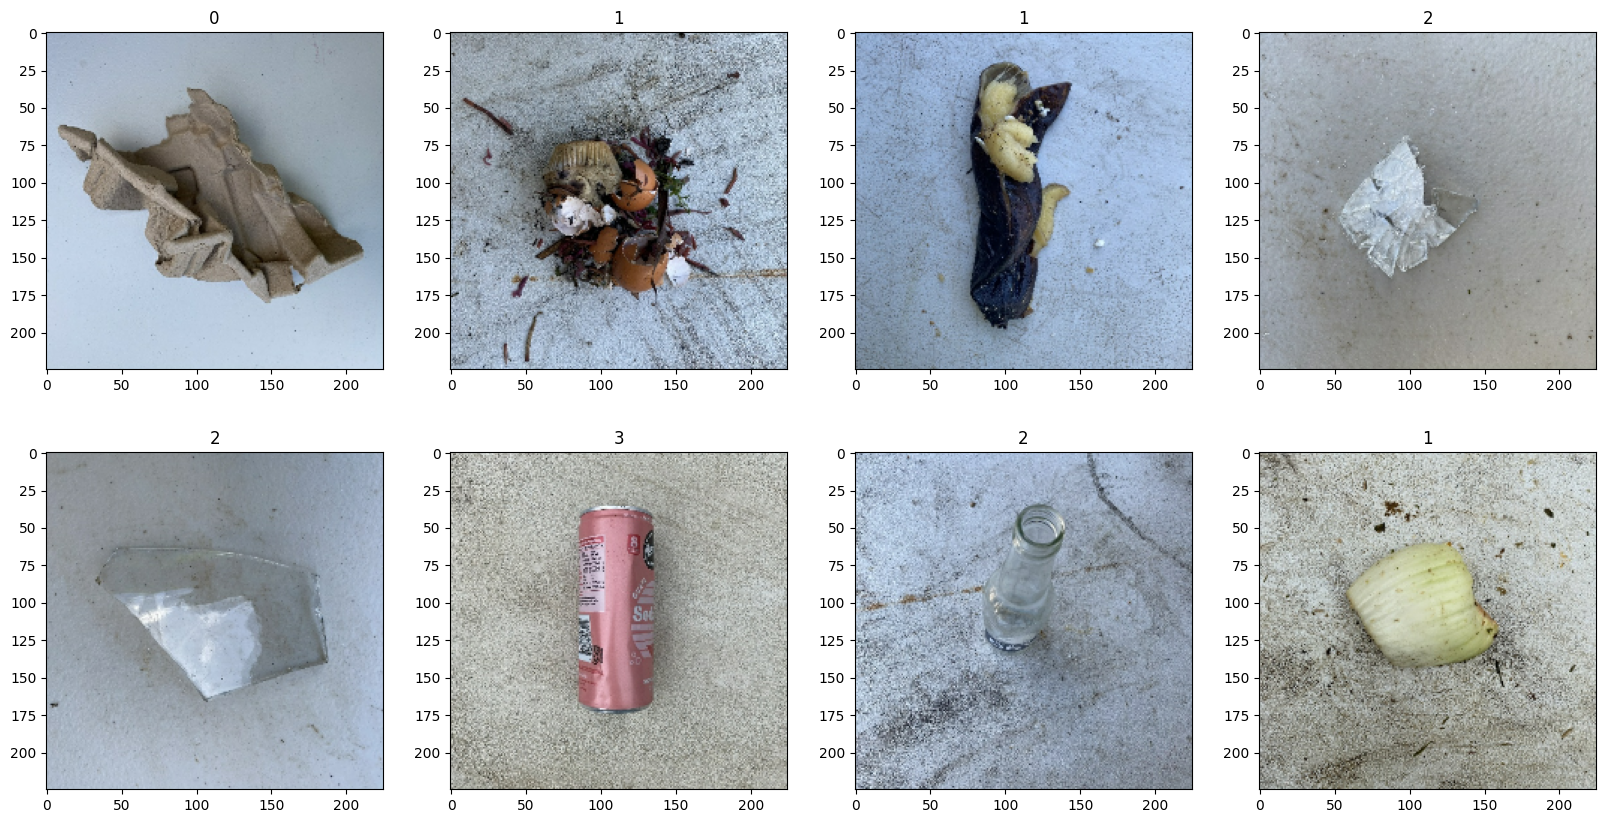

In [8]:
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (20,10))
ax = ax.flatten()
for idx,img in enumerate(batch[0][0:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
## normalization/scaling
data = data.map(lambda x,y : (x/255.0,y))

In [10]:
##spliting data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [11]:
len(data)

77

In [12]:
test_size+val_size+train_size

77

In [13]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(val_size+train_size).take(test_size)

In [36]:
base_model = VGG16(input_shape=(225, 225, 3),
                   include_top=False,
                   weights="imagenet")

In [37]:
##frezzing layers
for layer in base_model.layers:
    layer.trainable  = False

In [38]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 225, 225, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 225, 225, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 225, 225, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
model_layer = base_model.output  # shape (7, 7, 512)
model_layer = Flatten()(model_layer)
model_layer = Dropout(0.2)(model_layer)
model_layer = BatchNormalization()(model_layer)

model_layer = Dense(512, kernel_initializer='he_uniform')(model_layer)
model_layer = BatchNormalization()(model_layer)
model_layer = Activation("relu")(model_layer)
model_layer = Dropout(0.2)(model_layer)

model_layer = Dense(512, kernel_initializer='he_uniform')(model_layer)
model_layer = BatchNormalization()(model_layer)
model_layer = Activation("relu")(model_layer)
model_layer = Dropout(0.2)(model_layer)

# Output layer for 5 classes
outputs = Dense(5, activation='softmax')(model_layer)

# Final model
model = Model(inputs=base_model.input, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 225, 225, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 225, 225, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 225, 225, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,929,925 (106.54 MB)

 Trainable params: 13,163,013 (50.21 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [46]:
adam  = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = adam , metrics = ['accuracy'] ,loss = "sparse_categorical_crossentropy")

In [47]:
filepath = './best_model.keras'

earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              patience=2,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True, 
                             verbose=1)

callback_list = [earlystopping, checkpoint]

In [48]:
history = model.fit(train_data,epochs = 5,callbacks = callback_list,validation_data = val_data)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6354 - loss: 0.9661
Epoch 1: val_accuracy improved from -inf to 0.75195, saving model to ./best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.6371 - loss: 0.9618 - val_accuracy: 0.7520 - val_loss: 0.7446
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9277 - loss: 0.2256
Epoch 2: val_accuracy improved from 0.75195 to 0.86523, saving model to ./best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 1191s 23s/step - accuracy: 0.9277 - loss: 0.2256 - val_accuracy: 0.8652 - val_loss: 0.4244
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9783 - loss: 0.0953
Epoch 3: val_accuracy improved from 0.86523 to 0.90234, saving model to ./best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 586s 11s/step - accuracy: 0.9781 - loss: 0.0956 - val_accuracy: 0.9023 - val_loss: 0.3116
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9921 - loss: 0.0444
Epoch 4: val_accuracy did not improve from 0.90234

Text(0.5, 0.98, 'Loss')

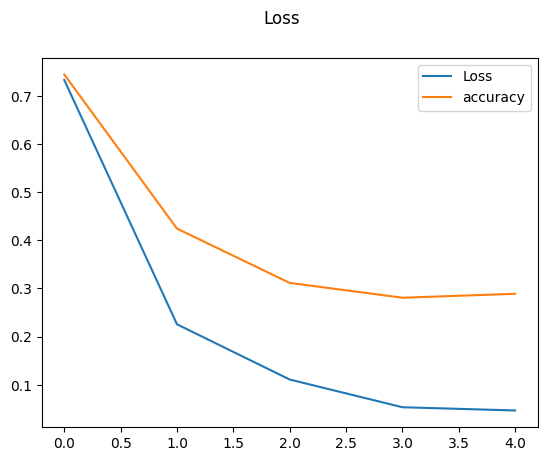

In [58]:
figure = plt.figure()
plt.plot(history.history["loss"],label = "Loss")
plt.plot(history.history["val_loss"],label = "accuracy")
plt.legend()
figure.suptitle("Loss")

Text(0.5, 0.98, 'Accuaracy')

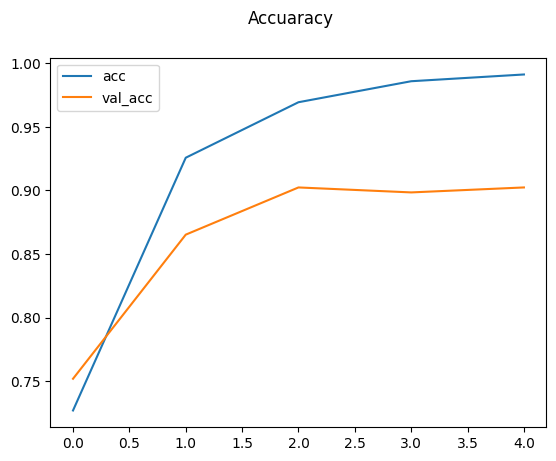

In [61]:
figure = plt.figure()
plt.plot(history.history["accuracy"],label = "acc")
plt.plot(history.history["val_accuracy"],label = "val_acc")
plt.legend()
figure.suptitle("Accuaracy")

In [64]:
loss, accuracy = model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9035 - loss: 0.3439


In [65]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Test Loss: 0.3706311583518982
Test Accuracy: 0.8955823183059692


In [71]:
model.save("vgg16_garbage_classification_model.h5",)

In [72]:
save_model??

Signature: save_model(model, filepath, overwrite=True, zipped=None, **kwargs)
Source:   
@keras_export(["keras.saving.save_model", "keras.models.save_model"])
def save_model(model, filepath, overwrite=True, zipped=None, **kwargs):
    """Saves a model as a `.keras` file.

    Args:
        model: Keras model instance to be saved.
        filepath: `str` or `pathlib.Path` object. Path where to save the model.
        overwrite: Whether we should overwrite any existing model at the target
            location, or instead ask the user via an interactive prompt.
        zipped: Whether to save the model as a zipped `.keras`
            archive (default when saving locally), or as an unzipped directory
            (default when saving on the Hugging Face Hub).

    Example:

    ```python
    model = keras.Sequential(
        [
            keras.layers.Dense(5, input_shape=(3,)),
            keras.layers.Softmax(),
        ],
    )
    model.save("model.keras")
    loaded_model = keras.savi

In [ ]:
End of program....